First cell only scrapes data and creates/pickles data frame and can be skipped if you don't need more than the 2018 Hot 100 charts.

In [ ]:
import billboard
import numpy as np
import pandas as pd

week_counter = 53
chart_type = 'hot-100'
chart_date = '2018-12-29'
chart = billboard.ChartData(chart_type, date=chart_date)

COLUMN_NAMES = ['date', 'rank', 'artist', 'title', 'is_new', 'last_pos', 'peak_pos', 'weeks']
output_df = pd.DataFrame(columns=COLUMN_NAMES)

for i in range(0, week_counter):
    for entry in range(0, 100):
        song = chart[entry]
        row = pd.Series([chart.date,
                         song.rank,
                         song.artist,
                         song.title,
                         song.isNew,
                         song.lastPos,
                         song.peakPos,
                         song.weeks],
                       index=COLUMN_NAMES)
        
        output_df = output_df.append(row, ignore_index=True)
                        
    chart_date = chart.previousDate
    chart = billboard.ChartData(chart_type, chart_date)

output_df = output_df.astype({'date': np.datetime64,
                              'rank': np.int8,
                              'is_new': np.bool,
                              'last_pos': np.int8,
                              'peak_pos': np.int8,
                              'weeks': np.int8})

output_df.to_pickle('./2018-hot-100.pkl')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_pickle('./2018-hot-100.pkl')
df = df.set_index(['date', 'rank'])

In [2]:
week_counts = df['weeks'].value_counts().sort_index()
print(week_counts)

1     599
2     389
3     332
4     291
5     270
6     249
7     229
8     216
9     203
10    191
11    182
12    175
13    166
14    160
15    152
16    145
17    145
18    143
19    135
20    125
21     78
22     67
23     59
24     52
25     48
26     45
27     42
28     38
29     36
30     29
31     26
32     25
33     24
34     25
35     24
36     21
37     19
38     17
39     15
40     14
41     11
42     10
43      8
44      8
45      6
46      6
47      5
48      5
49      6
50      7
51      7
52      7
53      2
54      3
55      2
56      2
57      2
58      1
59      1
Name: weeks, dtype: int64


In [3]:
df['weeks_max'] = df.groupby(['artist','title'])['weeks'].transform(max)
print(df[['artist', 'title', 'weeks', 'weeks_max']].head())

                                 artist  \
date       rank                           
2018-12-29 1              Ariana Grande   
           2                     Halsey   
           3               Travis Scott   
           4     Post Malone & Swae Lee   
           5      Marshmello & Bastille   

                                                         title  weeks  \
date       rank                                                         
2018-12-29 1                                     Thank U, Next      7   
           2                                        Without Me     11   
           3                                        Sicko Mode     20   
           4     Sunflower (Spider-Man: Into The Spider-Verse)      9   
           5                                           Happier     18   

                 weeks_max  
date       rank             
2018-12-29 1             7  
           2            11  
           3            20  
           4             9  
           5

In [4]:
weeks_max_df = df[['artist', 'title', 'weeks_max']].groupby(['artist', 'title']).first().sort_values(by='weeks_max')

print(weeks_max_df['weeks_max'].value_counts().sort_index())

1     220
2      66
3      48
4      27
5      26
6      22
7      15
8      20
9      14
10     12
11      7
12     16
13      8
14     14
15     10
16      6
17      7
18     11
19     12
20     50
21     11
22     11
23      9
24      6
25      4
26      4
27      4
28      2
29      7
30      3
31      1
32      1
33      1
34      2
35      3
36      3
37      2
38      2
39      1
40      3
41      2
42      2
44      2
45      1
46      1
48      1
52      5
54      1
57      1
59      1
Name: weeks_max, dtype: int64


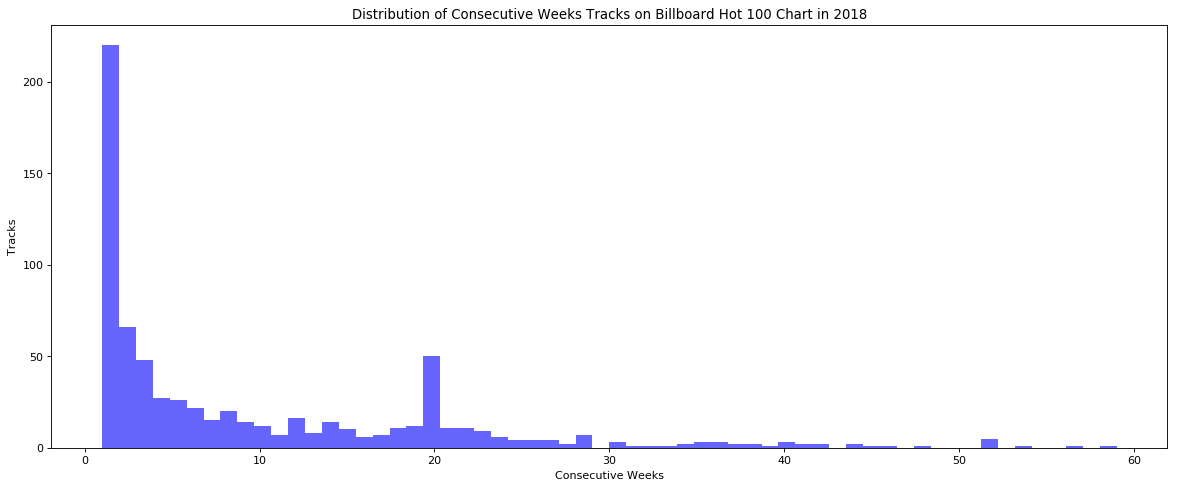

In [30]:
plt.figure(figsize=(18, 7), dpi= 80, facecolor='w', edgecolor='k')
weeks_max_df['weeks_max'].plot.hist(bins=60, color='b', alpha=0.6)

plt.xlabel('Consecutive Weeks')
plt.ylabel('Tracks')
plt.title('Distribution of Consecutive Weeks Tracks on Billboard Hot 100 Chart in 2018')
plt.grid(False)
plt.show()

In [26]:
df['peak_rank'] = df.groupby(['artist','title'])['peak_pos'].transform(min)
print(df[['artist', 'title', 'peak_rank', 'weeks_max']].head())

                                 artist  \
date       rank                           
2018-12-29 1              Ariana Grande   
           2                     Halsey   
           3               Travis Scott   
           4     Post Malone & Swae Lee   
           5      Marshmello & Bastille   

                                                         title  peak_rank  \
date       rank                                                             
2018-12-29 1                                     Thank U, Next          1   
           2                                        Without Me          2   
           3                                        Sicko Mode          1   
           4     Sunflower (Spider-Man: Into The Spider-Verse)          4   
           5                                           Happier          3   

                 weeks_max  
date       rank             
2018-12-29 1             7  
           2            11  
           3            20  
           4 

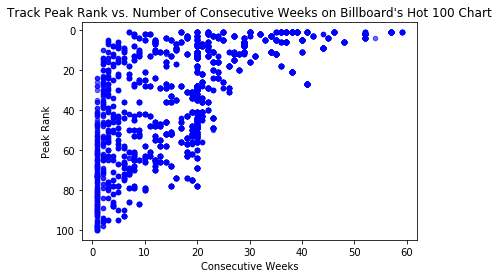

In [36]:
df.plot.scatter(x='weeks_max', y='peak_rank', color='b', alpha=0.6)

plt.xlabel('Consecutive Weeks')
plt.ylabel('Peak Rank')
plt.title('Track Peak Rank vs. Number of Consecutive Weeks on Billboard\'s Hot 100 Chart')
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()